### Лабораторная работа 2


### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии
- реализуете логистическую регрессию и её обучение градиентным спуском
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными

In [1]:
%pylab inline
import pandas as pd
from sklearn.linear_model import Ridge,Lasso
from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold,cross_val_predict
from sklearn.metrics import make_scorer

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Линейная регрессия

В этой части мы кратко познакомимся с линейной регрессией.

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3.

In [2]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.



Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$). Согласуются ли результаты с вашими ожиданиями?

In [3]:
from sklearn.linear_model import Lasso, Ridge

clf_l1 = Lasso()
clf_l1.fit(X_train, y_train)

Lasso()

In [4]:
clf_l1.coef_

array([  0.        ,   0.        , 274.33128438,  48.57203696,
         0.        ,   0.        ,  -0.        ,   0.        ,
       424.12142666,   0.        ])

In [5]:
clf_l2 = Ridge()
clf_l2.fit(X_train, y_train)

Ridge()

In [6]:
clf_l2.coef_

array([  20.86588099,  -58.00039065,  231.2704688 ,  186.67010355,
         33.31087207,   -2.16994737, -150.95049376,  141.35036492,
        250.75391278,  123.18025806])

Count:[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


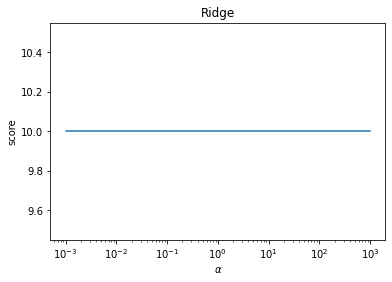

Count:[10, 10, 10, 9, 9, 7, 7, 4, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0]


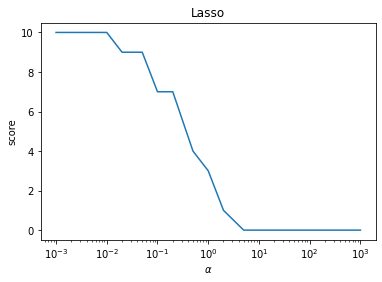

In [7]:
alphas = [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]

def count_coef(array):
  score = 0
  for num in array:
    if num != 0:
      score+=1
  return score

def show_plot(alphas, scores,text):
    figure = plt.figure()
    ax = figure.add_subplot(1, 1, 1)
    ax.plot(alphas, scores)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"score")
    ax.set_xscale("log")
    ax.set_title(text)
    plt.show()

def test_Ridge(alphas, *data):
    X_train,X_test, y_train,y_test=data
    scores = []
    for i, coef in enumerate(alphas):
      regr=Ridge(alpha=coef)
      regr.fit(X_train,y_train)
      scores.append(count_coef(regr.coef_))
    print('Count:%s' % scores)  
    show_plot(alphas,scores, "Ridge")


def test_Lasso(alphas, *data):
    X_train,X_test, y_train,y_test=data
    scores = []
    for i, coef in enumerate(alphas):
      lasso=Lasso(alpha=coef)
      lasso.fit(X_train,y_train)
      scores.append(count_coef(lasso.coef_))
    print('Count:%s' % scores)  
    show_plot(alphas,scores, "Lasso")



test_Ridge(alphas, X_train, X_test, y_train, y_test)
test_Lasso(alphas, X_train, X_test, y_train, y_test)

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

regr = Ridge()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

def print_metric(y_test, y_pred):
  print('RMSE test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_test, y_pred)))) 
        
  print('R^2 test: {:.3f}'.format(
        r2_score(y_test, y_pred)))
  
  print('MAE test: {:.3f}'.format(
        mean_absolute_error(y_test, y_pred)))
   
print_metric(y_test, y_pred)

RMSE test: 58.304
R^2 test: 0.360
MAE test: 49.603


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Для этого воспользуйтесь GridSearchCV и KFold из sklearn. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

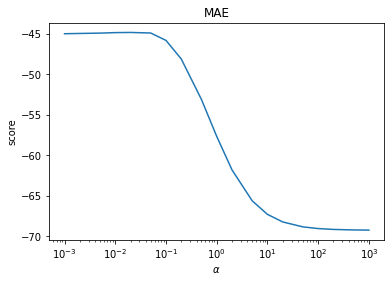

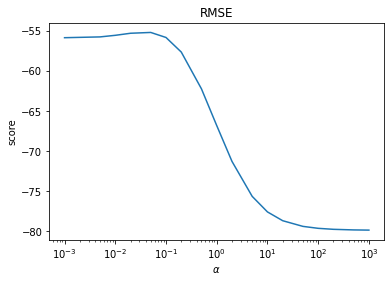

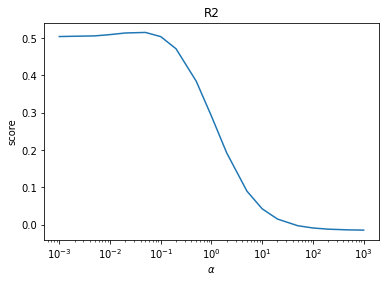

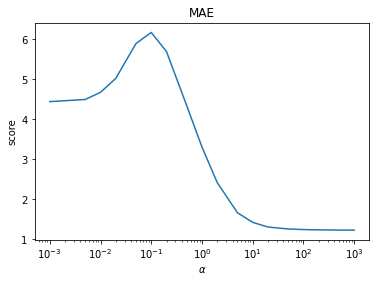

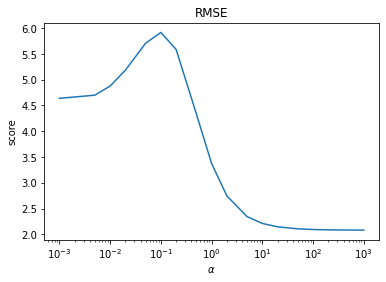

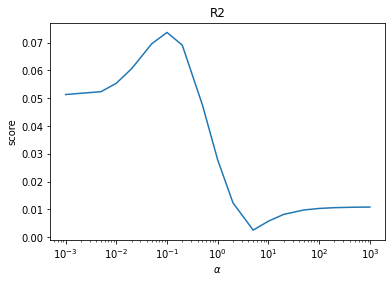


RMSE test: 55.716
R^2 test: 0.415
MAE test: 47.003


In [9]:
from sklearn import metrics

parametrs = {'alpha':alphas}
scoring={'mae':'neg_mean_absolute_error', 'rmse':'neg_root_mean_squared_error', 'R2':'r2'}
model = Ridge()
kf = KFold(n_splits=3)

rgr = GridSearchCV(model, parametrs, scoring=scoring, refit = 'mae',cv = kf.split(X_test))

rgr.fit(X_train, y_train)


# print(rgr.cv_results_['mean_test_mae'] )
# print(rgr.cv_results_['mean_test_rmse'] )
# print(rgr.cv_results_['mean_test_R2'] )
# print()
# print(rgr.cv_results_['std_test_mae'] )
# print(rgr.cv_results_['std_test_rmse'] )
# print(rgr.cv_results_['std_test_R2'] )
# print()
# print(rgr.best_score_)
# print(rgr.best_estimator_)
# print(rgr.best_params_)
# print()
# print(rgr.cv_results_['params'])

show_plot(list(rgr.cv_results_['param_alpha']),list(rgr.cv_results_['mean_test_mae']), 'MAE' )
print()
show_plot(list(rgr.cv_results_['param_alpha']),list(rgr.cv_results_['mean_test_rmse']), 'RMSE' )
print()
show_plot(list(rgr.cv_results_['param_alpha']),list(rgr.cv_results_['mean_test_R2']), 'R2' )
print()

show_plot(list(rgr.cv_results_['param_alpha']),list(rgr.cv_results_['std_test_mae']), 'MAE' )
print()
show_plot(list(rgr.cv_results_['param_alpha']),list(rgr.cv_results_['std_test_rmse']), 'RMSE' )
print()
show_plot(list(rgr.cv_results_['param_alpha']),list(rgr.cv_results_['std_test_R2']), 'R2' )
print()

result = rgr.best_estimator_
result.fit(X_train, y_train)

y_pred = result.predict(X_test)
print_metric(y_test, y_pred)


__Задание 2.__ Поиск объектов-выбросов



Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. С помощью cross_val_predict сделайте Out-of-Fold предсказания для обучающей выборки. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

[138.60010875 186.45881683 142.17925855 206.1198489  187.98085129
 134.49250855 158.69029545 185.88714446 182.21587824 171.96029421
 208.68257665 109.39838034 109.17255311 107.89585928 140.51852645
 127.15234811 181.69028447 139.98288283 153.04157494 165.57604476
 208.68972732 112.29642073 155.20289032 161.84356894 155.42213004
 142.52051151 162.83377667 131.20852518 161.5130229  103.54810412
 158.23104586 176.697782   162.35326715 156.7953882  148.98625112
 126.17047652 126.41379894 170.24539736 162.01965311 111.87594014
 123.8658706  108.55244357 205.51345144 198.76074066 176.61110267
 169.95682182 102.27340502 171.90219167 102.63856547 123.65977036
 168.42799372 169.68490247 163.28062787 100.27285807 182.07112715
 145.96976904 150.02746533 183.87349504 132.69878712 135.77340005
 126.97627189 183.62684935 154.58922244  97.01674465 166.94046982
 192.57889157 166.14439784 127.53611104 167.63939092 157.2246391
 135.2621271  128.01587171 140.75235148  93.39327766 135.77470949
 103.811605

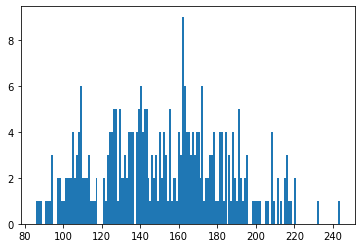

In [10]:
y_cross_pred =  cross_val_predict(regr, X_train, y_train, cv = kf.split(X_train))

print(y_cross_pred)
print()
plt.hist(y_cross_pred, bins=np.arange(min(y_cross_pred), max(y_cross_pred)+1))
plt.show()

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [11]:
bottom_X = np.mean(X_train) - 3*np.std(X_train)
top_X = np.mean(X_train) + 3*np.std(X_train)
bottom_Y = np.mean(y_train) - 3*np.std(y_train)
top_Y = np.mean(y_train) + 3*np.std(y_train)
print(bottom_X, top_X)
print()
print(bottom_Y, top_Y)
print()

testx = X_train.tolist()
testy = y_train.tolist()

lenX = len(testx)

for  i in np.arange(0,lenX ): 
  for j, item in enumerate(testx[i]):
    if(item<bottom_X):
      testx[i][j] = bottom_X
    if(item>top_X):
      testx[i][j]=top_X
   
print()

for  i,item in enumerate(testy): 
    if(item<bottom_Y):
      testy[i] = bottom_Y
    if(item>top_Y):
      testy[i]=top_Y
   
print()

x_train = np.array(testx,dtype=float)
y = np.array(testy,dtype=float)


res = rgr.best_estimator_
res.fit(x_train, y)

y_pred = res.predict(X_test)
print(y_pred)


-0.14207570294990257 0.14334817333964195

-84.10546094118843 388.1960758279198



[122.26543841 192.02683039 125.55849878  60.28581858  50.55284291
 233.61802511 213.5018755  225.63551755 162.04758451 175.33428496
  90.17235139 248.34157235  86.48825854 212.00111468 241.05569297
 128.38921179 177.77333054  62.39368419 150.67239839  47.51558277
 182.26690608 122.89819974 105.89945759 131.99077495 226.85910998
 210.59211846 178.89085921 150.64450482 159.50169484 195.12337689
 163.66748916  97.87318541 183.31185671 173.70803855 253.27785588
 186.42082451 123.99019858 173.44302446 185.38677502  79.33068177
 149.70313746 107.34711839 134.38404918  86.45763028 104.44455124
  45.3088175  112.10298022  40.94844744 143.71618882  72.96303512
 234.42089832  79.95496775  96.09762054 144.95320697 147.12653199
 132.34198815 146.82544684 130.65973111 208.033766   126.35248103
 214.19293897 218.03600823 243.23517539  74.96844176  90.35035901
 177.21370145 121.17192146  63.98924712 147.32475657 142.911

## Часть 2. Логистическая регрессия

В этой части мы будем реализовывать один из самых простых бинарных классификаторов — логистическую регрессию и её обучение с помощью обычного (полного) и стохастического градиентных спусков.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). В случае стохастического градиентного спуска $\nabla_w Q(w, X) \approx \nabla_w q_{i_k} (w)$, где $i_k$ — случайно выбранный номер слагаемого из функционала (регуляризатор можно внести в сумму, предварительно умножив и разделив на $l$). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Формулу для градиента функции потерь логистической регрессии вы должны были выводить в рамках одной из задач четвёртого теоретического домашнего задания. Но на всякий случай мы её повторим. Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Вероятность принадлежности объекта $x$ классу $+1$ вычисляется следующим образом:

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- \langle w, x \rangle )}
$$

Не забывайте, что матрицу объекты-признаки $X$ необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из 2 способов, разобранных на лекциях). Для этого можно воспользоваться StandardScaler или сделать это вручную.

В логистической регрессии также можно использовать $L_1$-регуляризацию. Тогда в функцию потерь добавится слагаемое $\lambda_1 \lVert w \rVert _1$. В формуле для вычисления градиента фукнции потерь по вектору коэффициентов это слагаемое будет соответствовать $\lambda_1 sgn(w)$, где $sgn$ — вычисление знака числа, применяемое к вектору коэффициентов поэлементо.

__Задание 1.__ Реализация обучения и применения логистической регресии c $L_2$-регуляризацией. 



Используйте для этого указанные ниже прототипы. Для эффективности все вычисления производите в векторизованной форме без циклов (кроме самих итераций градиентного спуска). Сгенерируйте с помощью функции make\_classification из модуля sklearn.datasets небольшую выборку для тестирования и исследования (выборка не должна быть слишком простой для классификации; также не забудьте проверить, что метки объектов из необходимого нам множества). Постройте следующие графики (для полного и стохастического градиентного спуска на одном графике):
- функции потерь от номера итерации обучения
- затраченного времени от номера итерации обучения

Возьмите параметр регуляризации $\lambda_2=1$, точность $tolerance=10^{-6}$, максимальное число итераций $max\_iter=1000$. Подберите оптимальную на ваш взгляд величину шага градиентного спуска. 

Сделайте выводы о том, чем различается на практике обучение с помощью стохастического градиентного спуска по сравнению с полным градиентным спуском.

В этом задании не обращайте внимания на $\lambda_1$, соответствующий $L_1$-регуляризации.

Для численной устойчивости вам могут быть полезны функции: scipy.special.expit и numpy.logaddexp.

__Важно:__ код с реализацией логистической регрессии необходимо также отправить на проверку в Яндекс.контест (ссылка [раз](https://official.contest.yandex.ru/contest/5704/problems/) и [альтернативная](https://contest.yandex.ru/contest/5704/problems/)). Не забывайте про pep8. 

ID посылки: ...

__Бонусное задание.__ Реализация $L_1$-регуляризации и обучение с помощью субградиентного спуска.

__(1.0 балла)__

Модифицируйте реализацию так, чтобы можно было обучать логистическиую регрессию с $L_1$-регуляризацией (и даже одновременно с двумя видами). Проведите аналогичные эксперименты, считая $\lambda_1 = 0.001, \lambda_2 = 0$.

Стоит помнить, что модуль — недифференцируемая в нуле функция, поэтому мы не можем применить обычный градиентный спуск. Вместо этого будем применить субградиентный спуск — аналогичный градиентному спуску метод, в котором используется субградиент функции. 

Вектор $g \in \mathbb{R}$ называется субградиентом выпуклой функции $f$ в точке $x$, если $\forall z \in \mathbb{R}$ выполнено неравенство: $f(z) \ge f(x) + g^T (z-x)$. Если функция $f$ дифференцируема в точке $x$, её субградиент в этой точке совпадает с градиентом. Субдифференциалом функции $f$ называют множество субградиентов в этой точке.

Для $f(x) = |x|$ при $x = 0$ субдифференциал определяется неравенством $|z| \ge gz$, поэтому $g \in [-1, 1]$. 

На практике для стабильности процесса обучения для близких к нулю значений можно уменьшать градиент, умножая на небольшое число (например, 0.1-0.5) или делая его нулевым (только околонулевые координаты!)

In [12]:
from scipy.special import expit
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from time import time

class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic', 
                 tolerance=1e-6, max_iter=1000, w0=None, alpha=1e-3):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = None
        self.time_history = None
        
            
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """

        X = np.hstack((X, np.ones(X.shape[0])[:,np.newaxis]))

        d = X.shape[1] # кол-во столбцов
        self.w = self.w0

        if self.w is None:
            self.w = np.random.uniform(-1 / d, 1 / d, d)

        self.loss_history = []
        self.time_history = []

        if self.gd_type == 'stochastic':
            self.loss_history.append(self.calc_loss(X, y))
            start = time()
            self.time_history.append(start - start)

            for i in range(self.max_iter):
                old_w = np.copy(self.w)
                grad = self.calc_gradient(X[i:i + 1], y[i:i + 1])
                grad_step = self.alpha * grad
                self.w -= grad_step
                self.time_history.append(time() - start)
                self.loss_history.append(self.calc_loss(X, y))

                if np.linalg.norm(self.w - old_w) < self.tolerance:
                    break

        if self.gd_type == 'full':
            self.loss_history.append(self.calc_loss(X, y))
            start = time()
            self.time_history.append(start - start)

            for i in range(self.max_iter):
                old_w = np.copy(self.w)
                grad_step = self.alpha * self.calc_gradient(X, y)
                self.w -= grad_step
                self.time_history.append(time() - start)
                self.loss_history.append(self.calc_loss(X, y))

                if np.linalg.norm(self.w - old_w) < self.tolerance:
                    break

        return self
    
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        X = np.hstack((X, np.ones(X.shape[0])[:,np.newaxis]))
        
        proba = expit(np.einsum('j,ij->i', self.w, X))
        proba = np.stack((1 - proba, proba), axis=-1)

        return proba
                             
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        
        reg = self.lambda_2 * self.w
        main1 = (y[:, np.newaxis] * X)
        main2 = expit(- y * X.dot(self.w))[:, np.newaxis]
        return (-(main1 * main2)).mean(axis=0) + reg

    def calc_loss(self, X, y, out=False):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float
        """        
        if out:
            X = np.hstack((X, np.ones(X.shape[0])[:,np.newaxis]))
        reg = self.lambda_2 * np.sum(self.w ** 2) / 2
        main = np.logaddexp(0, -y * np.einsum('j,ij->i', self.w, X))
        return np.mean(main) + reg

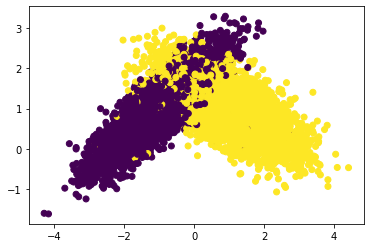

In [13]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=228)

plt.scatter(X[:,0], X[:,1], c=y)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

lr = LogReg(alpha=0.001, gd_type='stochastic')
lr.fit(X_train, y_train)

LogReg()

In [15]:
stoch_loss = lr.loss_history
n_iter = np.arange(len(stoch_loss))
stoch_time = lr.time_history

In [16]:
lr = LogReg(alpha=0.001, gd_type='full')
lr.fit(X_train, y_train)

LogReg(gd_type='full')

In [17]:
full_loss = lr.loss_history
full_time = lr.time_history

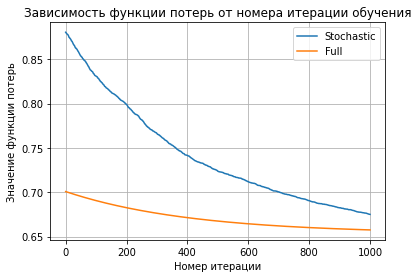

In [18]:
plt.plot(n_iter, stoch_loss, label="Stochastic")
plt.plot(n_iter, full_loss, label="Full")
plt.title(u"Зависимость функции потерь от номера итерации обучения")
plt.xlabel(u"Номер итерации")
plt.ylabel(u"Значение функции потерь")
plt.grid()
plt.legend()
plt.rcParams["figure.figsize"] = (9,6)

plt.show()

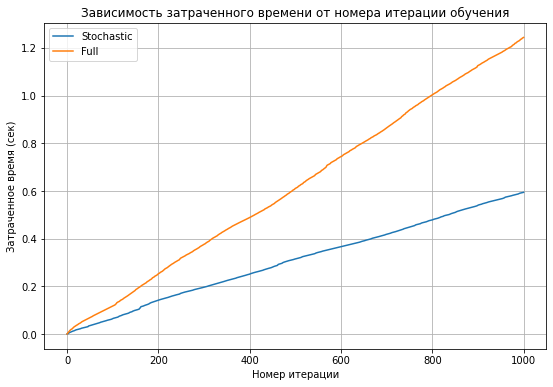

In [19]:
plt.plot(n_iter, stoch_time, label="Stochastic")
plt.plot(n_iter, full_time, label="Full")
plt.title(u"Зависимость затраченного времени от номера итерации обучения")
plt.xlabel(u"Номер итерации")
plt.ylabel(u"Затраченное время (сек)")
plt.grid()
plt.legend()
plt.rcParams["figure.figsize"] = (9,6)

plt.show()

__Выводы:__ ...

__Задание 2.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.



Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Загрузим данные с актуального сейчас конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [20]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [21]:
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [22]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [23]:
lr = LogReg(alpha=0.001, gd_type='stochastic', tolerance=1e-6, max_iter=500)
lr.fit(X_train, y_train)
pred = lr.predict_proba(X_test)

Постройку ROC-кривую и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1399227088.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


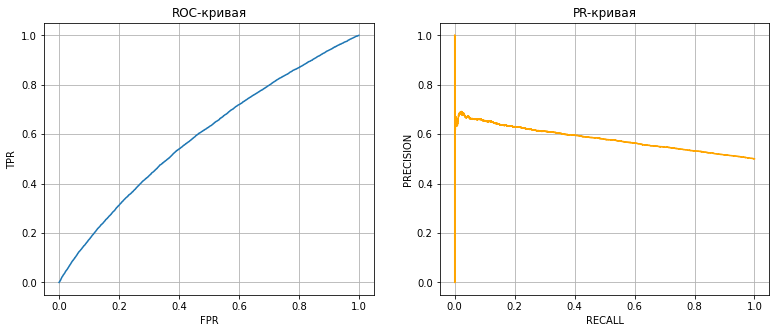

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])
precision, recall, tresholds = precision_recall_curve(y_test, pred[:,1])

ax1.plot(fpr, tpr)
ax2.plot(recall, precision, color="orange")

ax1.set_title('ROC-кривая')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")
ax1.grid()

ax2.set_title('PR-кривая')
ax2.set_xlabel('RECALL')
ax2.set_ylabel('PRECISION')
ax2.grid()

f.show()

In [25]:
roc_auc_score(y_test, pred[:,1])

0.5927999385363191

In [26]:
average_precision_score(y_test, pred[:,1])

0.5818327835021535

Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [27]:
thresh = max(tresholds[recall[:-1] >= 0.7])
prec = max(precision[recall >= 0.7])

In [28]:
thresh

0.5058683037352293

In [29]:
prec

0.5481265846558362

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred[:,1] > thresh)
# tn fp
# fn tp

array([[21131, 28863],
       [15002, 35004]])

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, pred[:,1] > thresh).ravel()

In [32]:
tn, fp, fn, tp

(21131, 28863, 15002, 35004)

__Задание 3.__ Изучение влияния регуляризатора на процесс обучения



Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [33]:
loss_train = []
loss_test = []

for i in range(1000):
    w = lr.w
    lr = LogReg(alpha=0.01, gd_type='full', tolerance=1e-6, max_iter=1, w0=w, lambda_2=0)
    lr.fit(X_train, y_train)
    loss_train.append(lr.calc_loss(X_train, y_train, True))
    loss_test.append(lr.calc_loss(X_test, y_test, True))

In [34]:
loss_train_reg = []
loss_test_reg = []

for i in range(1000):
    w = lr.w
    lr = LogReg(alpha=0.01, gd_type='full', tolerance=1e-6, max_iter=1, w0=w, lambda_2=1)
    lr.fit(X_train, y_train)
    loss_train_reg.append(lr.calc_loss(X_train, y_train, True))
    loss_test_reg.append(lr.calc_loss(X_test, y_test, True))

/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1879922931.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


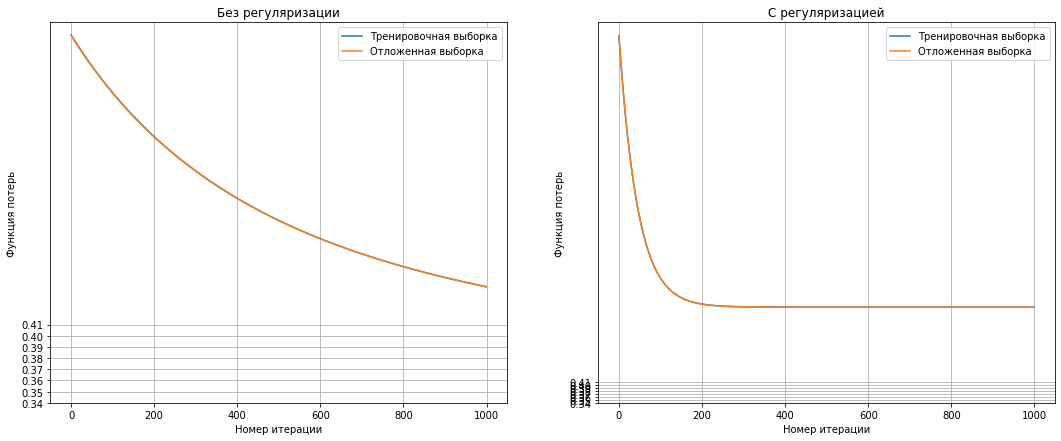

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

n_iter = np.arange(len(loss_train))

ax1.plot(n_iter, loss_train, label="Тренировочная выборка")
ax1.plot(n_iter, loss_test, label="Отложенная выборка")

ax2.plot(n_iter, loss_train_reg, label="Тренировочная выборка")
ax2.plot(n_iter, loss_test_reg, label="Отложенная выборка")

ax1.set_title(u"Без регуляризации")
ax1.set_xlabel(u"Номер итерации")
ax1.set_ylabel(u"Функция потерь")
ax1.set_yticks(np.arange(0.34, 0.42, 0.01))
ax1.legend()
ax1.grid()

ax2.set_title(u"C регуляризацией")
ax2.set_xlabel(u"Номер итерации")
ax2.set_ylabel(u"Функция потерь")
ax2.set_yticks(np.arange(0.34, 0.42, 0.01))
ax2.legend()
ax2.grid()

f.show()

## Часть 3. Метод опорных векторов и калибровка вероятностней

__Задание 1.__ Обучение и применение метода опорных векторов.



Обучите метод опорных векторов (в этот раз воспользуйтесь готовой реализацией LinearSVC из sklearn). Используйте уже загруженные и обработанные в предыдущей части данные.

In [36]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, y_train)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

На той же тестовой части посчитайте все те же метрики. Что вы можете сказать о полученных результатах?

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_pred)
aps = average_precision_score(y_test, y_pred)

In [38]:
rmse

0.6423316900169258

In [39]:
mae

0.41259

In [40]:
r2

-0.6503600237651848

In [41]:
rocauc

0.5874147568587725

In [42]:
aps

0.552065510438845

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов с линейным ядром. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром, так как только в нём есть информация об опорных векторах.

In [43]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=2007)
#маленькая выборка для того, чтобы график не выглядел нагроможденным

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2007)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

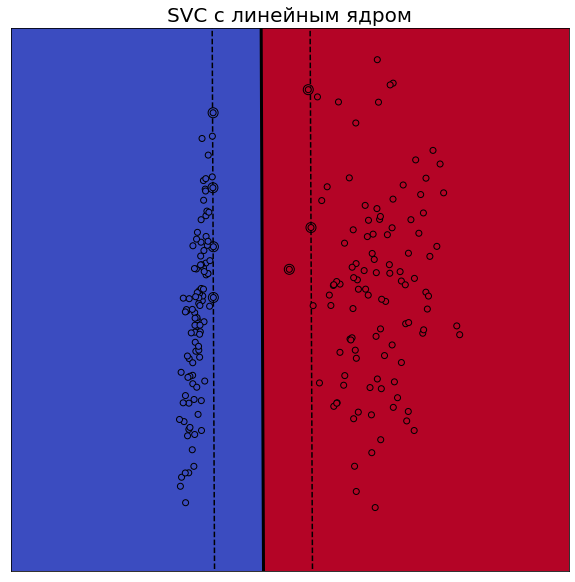

In [44]:
X = X_train
Y = y_train
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

plt.figure(figsize=(10,10))
plt.clf()
plt.plot(xx, yy, 'k-', linewidth=3)
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.coolwarm,
            edgecolors='k')

plt.axis('tight')
x_min = -3
x_max = 3
y_min = -3
y_max = 3

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.coolwarm)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.title("SVC с линейным ядром", fontsize=20)

plt.show()

__Задание 2.__ Калибровка вероятностей.



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [45]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) #bin_middle_points.append((l - r) / 2)
        bin_real_ratios.append(np.nanmean(y_test[(preds >= l) & (preds < r)] == 1)) #вместо min надо mean
    plt.plot(bin_middle_points, bin_real_ratios)

Посмотройте калибровочные кривые для логистической регрессии и метода опорных векторов (на той же самой выборке с тем же самым разбиением — можно использовать уже полученные ранее предсказания). Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

In [46]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [47]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [48]:
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


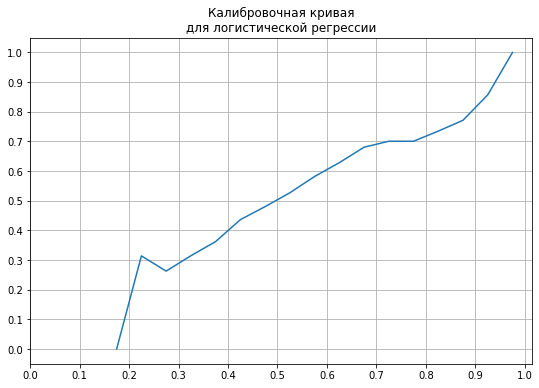

In [49]:
pred_lr = lr.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, pred_lr)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title(u"Калибровочная кривая\nдля логистической регрессии")
plt.grid()
plt.show()

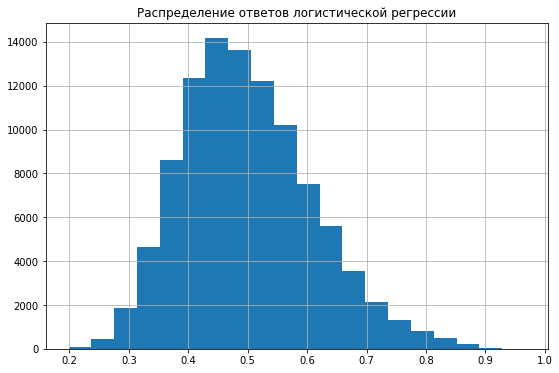

In [50]:
plt.hist(pred_lr, bins=20)
plt.title(u"Распределение ответов логистической регрессии")
plt.grid()
plt.show()

In [51]:
clf = LinearSVC()
clf.fit(X_train, y_train)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

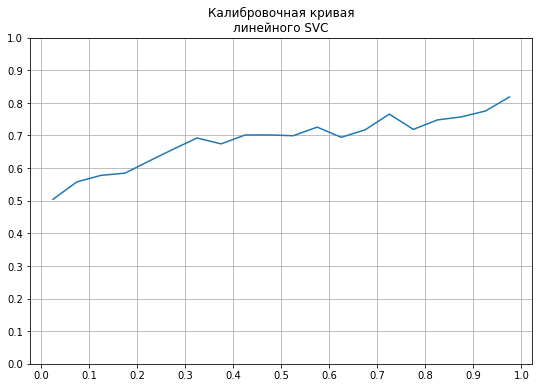

In [52]:
pred_svc = clf.decision_function(X_test)
#pred_svc = expit(pred_svc)
plot_calibration_curve(y_test, pred_svc)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title(u"Калибровочная кривая\nлинейного SVC")
plt.grid()
plt.show()

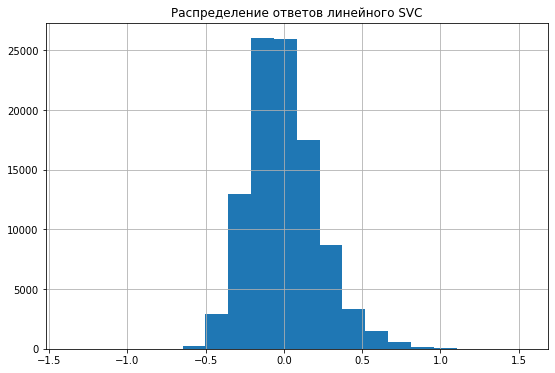

In [53]:
plt.hist(pred_svc, bins=20)
plt.title(u"Распределение ответов линейного SVC")
plt.grid()
plt.show()
plt.show()

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [54]:
from sklearn.calibration import CalibratedClassifierCV
calibration = CalibratedClassifierCV()
calibration.fit(X_train, y_train)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV()

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


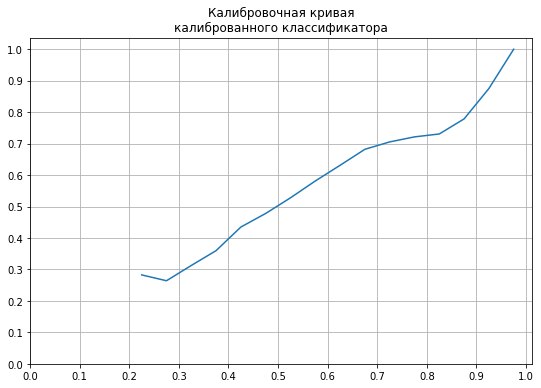

In [55]:
pred_cal = calibration.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, pred_cal)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title(u"Калибровочная кривая\nкалиброванного классификатора")
plt.grid()
plt.show()

## Часть 4. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.



In [56]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

In [57]:
data = data.reset_index()

In [58]:
del data['id']

In [59]:
categ = []
non_categ = []

for col in data.columns:
    if "cat" in col:
        categ.append(col)
    else:
        non_categ.append(col)

In [60]:
from sklearn.feature_extraction import DictVectorizer

data[non_categ] = data[non_categ].fillna(0)
data = data.fillna('nan')

for i in categ:
    data[i] = data[i].apply(lambda x: str(x))
    
scaler = StandardScaler()
data[non_categ] = scaler.fit_transform(data[non_categ])

dv = DictVectorizer(sparse=False)
data = dv.fit_transform(data.T.to_dict().values())

In [61]:
data.shape

(200000, 226)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [63]:
from time import time

lr = LogisticRegression(C=1)
start = time()
lr.fit(X_train, y_train)
stop = time()
pred = lr.predict_proba(X_test)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
stop - start 

3.956434965133667

In [65]:
roc_auc_score(y_test, pred[:,1])

0.6328970395137173

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?



In [66]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

In [67]:
for col in categ:
    vals = list(data[col].value_counts().index)
    for val in vals:
        mean = target[data[col] == val].mean()
        data[col][data[col] == val] = mean

/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1525754542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col] == val] = mean
/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1525754542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col] == val] = mean
/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1525754542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

lr = LogisticRegression(C=1)
start = time()
lr.fit(X_train, y_train)
stop = time()
pred = lr.predict_proba(X_test)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
data.shape

(200000, 57)

In [70]:
stop - start

1.562406063079834

In [71]:
roc_auc_score(y_test, pred[:,1])

0.6244994161927916

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки. 

__Задание 3.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [72]:
mu, sigma = 0, 0.01

for col in categ:
    data[col] = data[col] + np.random.normal(mu, sigma, len(data[col]))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

lr = LogisticRegression(C=1)
start = time()
lr.fit(X_train, y_train)
stop = time()
pred = lr.predict_proba(X_test)

/Users/kirillkumma/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
roc_auc_score(y_test, pred[:,1])

0.6184721084637641

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1] + C * global\_mean}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 4.__ Добавьте сглаживание, описанное выше и повторите эксперименты.



In [75]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

C = 10

for col in categ:
    glob_mean = target.mean()
    vals = list(data[col].value_counts().index)
    for val in vals:
        length = len(target[data[col] == val])
        summ = target[data[col] == val].sum()
        data[col][data[col] == val] = (summ + C * glob_mean) / (length + C)
        
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
pred = lr.predict_proba(X_test)
roc_auc_score(y_test, pred[:,1])

/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1630858273.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col] == val] = (summ + C * glob_mean) / (length + C)
/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1630858273.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col] == val] = (summ + C * glob_mean) / (length + C)
/var/folders/z5/chcv42xx5dz5tvj1sndvslmr0000gn/T/ipykernel_41290/1630858273.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

0.6245001693928024

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

__Ответ:__ 

Плюсы:
* При использовании счётчиков количество признаков остаётся неизменным, а при использовании one-hot кодирования оно резко возрастает, что может сказаться на времени обучения. Таким образом, чем больше выборка, и чем больше в выборке категориальных признаков, тем выгоднее по времени использовать счётчики.

Минусы:
* Целевая переменная "утекает" в данные.
* Для того, чтобы не утекала, приходится поднапрячься -- возникают различные методы для этого, и в этих методах появляются какие-то параметры, которые надо подбирать.

Плюс-минус:
* Счётчики добавляют в данные информацию, которой не было в них в явном виде.